# Helper Functions

In [1]:
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v  # Cannot normalize a zero vector
    return v / norm

def create_orig_df(x, lr):
    '''
    x: design matrix.
    lr: linear regression object.
    '''
    scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
    inds = np.argsort(scores)
    print("inds", inds[:10])
    original_inds = inds # original_inds

    newton_inds = np.argsort(newton_scores)
    print("newton inds", newton_inds[:10])
    original_newton_inds = newton_inds 

    # sort scores.
    sorted_scores = scores[inds]
    print("sorted_scores", sorted(scores)[:10])
    original_sorted_scores = sorted_scores

    sorted_newton_scores = newton_scores[inds]
    print("sorted_newton_scores", sorted_newton_scores[:10])
    original_sorted_newton_scores = sorted_newton_scores

    # residuals
    residuals = lr.residual()
    # print("residuals", residuals[:10])
    # leverages
    leverages = lr.leverage_scores()
    # print("leverages", leverages[:10])

    # x's
    intercept = [pt[0] for pt in x]
    x1 = [pt[1] for pt in x]
    # x2 = [pt[2] for pt in x]

    # x1 = [pt[0] for pt in x]
    # x2 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': scores, 'newton': newton_scores})
    
    print(orig_df[:13])
    
    return orig_df, inds, scores, newton_inds, newton_scores

def plot_dropped_point(x, y, index_to_remove):
    '''
    orig_df: df sorted by original indexing (where the outlier population comes first).
    index_to_drop: index returned from sorting by influence (or one-step newton) scores.
    method: "influence" or "newton"
    '''
    
    # V. Plot Dropped Point at Current Iteration
    plt.figure(figsize=(9, 7))
    plt.scatter(x.T[1][index_to_remove], y[index_to_remove], marker='x', color='black', label='Dropped point')
    
    # match the window of the original plot.
    plt.xlim(-2, 0.05)
    plt.ylim(-7, 3)
    
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Dropped Point')
    plt.legend()
    
    plt.show()
    
    return

def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''
    
    # IV. Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("index 0 in create_plot", sorted_if_df.index[0])
    
    # sorted_if_df # the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    
    sorted_if_df['sorted_idx'] = index
    
    # V. Plot Points Dropped
    plt.figure(figsize=(9, 7))

    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B


    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

In [2]:
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import numpy.typing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import linear_regression
from linear_regression import LinearRegression

# Multicollinearity Example with Noise

In this example of multicollinearity, we present two Gaussian distributions, where the smaller population (population A) consists of $<1\%$ of the datapoints. Upon dropping population A, most of the variation along the x axis is lost, and collinearity becomes a concern between x and the intercept. Here, dropping only 10 datapoints in population A suffices to flip the sign of the effect size from 3.90 to -0.79.

This is another example in which AMIP fails in both type (i) and type (ii) sense. That is, AMIP approximates that the largest effect size for the removal of 10 datapoints is -0.48 (failure type i), which is not enough to change the sign. In addition, AMIP fails to correctly identify subset A as the correct subset to remove (failure type ii). Similarly, 1sN fails in this case. That is, 1sN approximates that the largest effect size for the removal of 10 datapoints is -0.52 (failure type i). 1sN also fails to correctly identify subset A as the correct subset to remove (failure type ii). In running the greedy versions of these algorithms on this Simpson's paradox example, we find that both greedy AMIP and greedy 1sN are able to succeed in identifying population A as an influential subset that reverses the sign.

In running the greedy versions of these algorithms on this multicollinearity example, we find that both greedy AMIP and greedy 1sN are able to successfully identify population A as the influential subset that reverses the sign.


The variance in x for population A is 0.01 while the variance for population B is 1e-3. The residual for population A is 1.
The estimated fit for the full dataset is 3.90. The fit for pop A is -9.25 and the fit for pop B is -0.79. 

In [3]:
np.random.seed(2)
# Mixing proportions
total_observations = 1010
num_observations_pop_1 = 10 # A (small fraction)
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

# I. Generate the data.
mean_pop_1 = np.array([-1])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[.01]])
vars_pop_2 = np.array([[1e-1]])

# generate the X values for two populations.
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)

x = np.append(x1, x2, axis=0) # All x samples
print(type(x))
x1_0 = [pt[0] for pt in x1]
# x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
# x2_1 = [pt[1] for pt in x2]


# add intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
# (3/20: make sure that x1, x2 come from this new design matrix.)
x1 = x[:10]
x2 = x[10:]

# Generating the Y values.
epsilon = np.random.normal(0, 1, num_observations_pop_1) # eps is the variance of the noise distribution.
slope = -1
intercept = -10

y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope*x1_0[i] + intercept + epsilon[i]) # change here to add residual noise.

y2 = np.random.randn(1, num_observations_pop_2) # No(0, 1)
y2 = y2[0] # format results of np.randn 
y = np.concatenate([y1, y2], axis=0)

<class 'numpy.ndarray'>


In [4]:
x1

array([[ 1.        , -1.04167578],
       [ 1.        , -1.00562668],
       [ 1.        , -1.21361961],
       [ 1.        , -0.83597292],
       [ 1.        , -1.17934356],
       [ 1.        , -1.08417474],
       [ 1.        , -0.94971186],
       [ 1.        , -1.12452881],
       [ 1.        , -1.10579522],
       [ 1.        , -1.09090076]])

In [5]:
# Compute condition numbers
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}"
)

print(
    f"Condition number Pop A: {np.linalg.cond(x1)} Pop B: {np.linalg.cond(x2)}"
)

Condition number of full dataset: 3.0229481911122917
Condition number Pop A: 20.258489328645037 Pop B: 3.1686185456950287


In [6]:
# II. Fit the regression.
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
print(
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}"
)

modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

### V. CREATE DF
orig_df, inds, scores, newton_inds, newton_scores = create_orig_df(x, lr)
print(f"amip additive scores: {sum(scores[:10])}")
print(f'newton additive scores: {sum(newton_scores[:10])}')


# III. Compute influence scores for first coefficient.
# scores = -lr.influence_scores()[0] # effect of removing a data point.
scores = -lr.influence_scores()[1] # after adding an intercept term, take the scores of coefficient 1.

print("A", np.mean(np.abs(scores[:10])), "B", np.mean(np.abs(scores[10:1000])))

# sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
inds = np.argsort(scores)
print("inds", inds[:10])
original_inds = inds

# ### V. Plot coordinates by AMIP drop order.
# plt.figure(figsize=(9, 7))
# plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='x', color='black', label='Pop. A') # pop A
# plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B

# # Add dropped order positioned by each point
# #     for index, row in sorted_if_df.iterrows():
# #         if row['sorted_idx'] < 10:
# #             plt.text(row['x1']-0.01, row['y'], int(row['sorted_idx']), ha='right', va='bottom', fontsize=20)


# plt.xlim(-2.5, 2.5)

# plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
# plt.ylabel('y', fontsize=22)  # Larger font for y-axis label

# # Set the size of tick marks
# plt.xticks(fontsize=20)  # Larger ticks for x-axis
# plt.yticks(fontsize=20)  # Larger ticks for y-axis

# plt.title('Modified Poor Conditioning Example', fontsize=22)

# plt.legend(fontsize=22)


# plt.savefig('modified_poor_conditioning_example_data.pdf')
# plt.show() 

Estimated beta1 with full dataset: 0.7264567487721101
Estimated beta1 pop A: -0.018852211447998105
Estimated beta1 pop B: -0.10492493650237363
inds [5 4 0 7 2 1 8 6 9 3]
newton inds [5 4 7 2 0 1 8 6 9 3]
sorted_scores [-0.08389003375397606, -0.08317945307976625, -0.07986912219233053, -0.0798542654088231, -0.07964384389665789, -0.07413543161702782, -0.07127236246874613, -0.06752252382789564, -0.06620398702130213, -0.05556694924147882]
sorted_newton_scores [-0.08483626 -0.08428011 -0.08070485 -0.08081939 -0.08075716 -0.07486188
 -0.0721068  -0.06811786 -0.06695948 -0.05595601]
          x1         y  residual  leverage  influence    newton
0  -1.041676 -9.512121 -8.682056  0.010355  -0.079869 -0.080705
1  -1.005627 -9.158502 -8.354625  0.009704  -0.074135 -0.074862
2  -1.213620 -8.361579 -7.406605  0.013786  -0.079644 -0.080757
3  -0.835973 -8.250522 -7.569891  0.006953  -0.055567 -0.055956
4  -1.179344 -8.894897 -7.964823  0.013059  -0.083179 -0.084280
5  -1.084175 -9.614648 -8.753709  

In [7]:
# June 25
amip_beta = lr.beta[1] + sum(scores[:10])

In [8]:
modified_lr.beta[1] - amip_beta

-0.0902437127664792

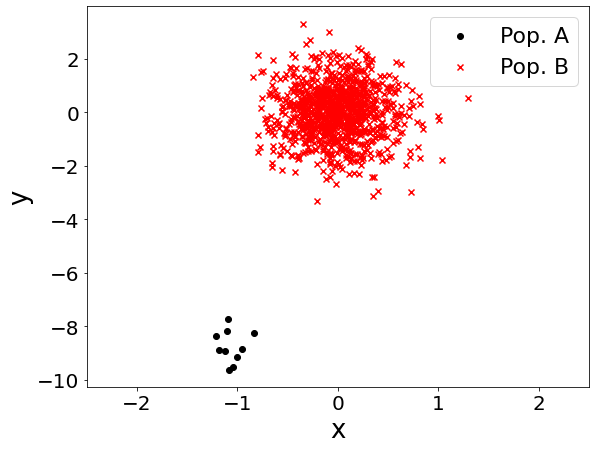

In [16]:
### V. Plot coordinates by AMIP drop order.
plt.figure(figsize=(9, 7))
plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A') # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B

# Add dropped order positioned by each point
#     for index, row in sorted_if_df.iterrows():
#         if row['sorted_idx'] < 10:
#             plt.text(row['x1']-0.01, row['y'], int(row['sorted_idx']), ha='right', va='bottom', fontsize=20)


plt.xlim(-2.5, 2.5)

plt.xlabel('x', fontsize=26)  # Larger font for x-axis label
plt.ylabel('y', fontsize=26)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=20)  # Larger ticks for x-axis
plt.yticks(fontsize=20)  # Larger ticks for y-axis

# plt.title('Modified Poor Conditioning Example', fontsize=22)
plt.legend(fontsize=22)
plt.savefig('modified_poor_conditioning_example_data.pdf')
plt.show()


In [17]:
# True change in fit.
0.726 - -0.104

0.83

In [18]:
# (June 25th) influence function new fit.
lr.beta[1] + sum(scores[:10])

-0.014681223735894422

In [19]:
# Refit after Removing Flagged Points
# AMIP inds [  0   5   1   3   6   7   4 775 237 405]
AMIP_inds= [0,5,1,3,6,7,4,775,237,405]
new_x_amip= np.delete(x, AMIP_inds, axis=0)
new_y_amip= np.delete(y, AMIP_inds, axis=0)
print(new_x_amip.shape)
print(new_y_amip.shape)
print(x.shape)

# newton inds [  0   5   1   6   3   7   4 775 237 405]
newton_inds= [0,5,1,6,3,7,4,775,237,405]
new_x_1sN= np.delete(x, newton_inds, axis=0)
new_y_1sN= np.delete(y, newton_inds, axis=0)


(1000, 2)
(1000,)
(1010, 2)


In [20]:
# Refit after removing the points specified by AMIP and Additive 1sN (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_amip = LinearRegression(x=new_x_amip.T, y=new_y_amip)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_amip.beta[1]}"
)
print(
    f"Difference in quantities: {lr.beta[1] - modified_lr_amip.beta[1]}"
)

Estimated beta1 with full dataset: 0.7264567487721101
Estimated beta1 after removing subset specified by AMIP: 0.1283554732812241
Difference in quantities: 0.598101275490886


In [21]:
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v  # Cannot normalize a zero vector
    return v / norm

In [22]:
# May 16th: compute (xtxinv - x2tx2inv)
xtxinv = np.linalg.inv(x.T @ x)
x2tx2inv = np.linalg.inv(x2.T @ x2)
M = xtxinv - x2tx2inv

In [23]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)

# The operator norm is the largest singular value
normM = np.max(s)
print(normM) # in the multicollinearity example, we find that the largest eigenvalue is much larger than in the simpson's paradox example.

largest_eigenvector = U[:, 0]
second_eigenvector = U[:, 1]

print(largest_eigenvector) # Multicollinearity: Largest eigenvalue of 0.922.
# print(U)

0.0010063524827340436
[-0.08044497  0.99675905]


In [24]:
# x1y1 = x1.T @ y1
# x1y1
# x2y2 = x2.T @ y2
# x2y2

In [25]:
x1y1 = x1.T @ y1
Sigma_s = x1.T @ x1
Sigma_inv = np.linalg.inv(x.T @ x)
xty = x.T @ y

In [26]:
error_vec = x1y1 - Sigma_s @ Sigma_inv @ Sigma_s @ xty

In [27]:
norm_error_vec = normalize_vector(error_vec)
norm_error_vec

array([ 0.67911133, -0.73403529])

In [28]:
# norm_x1y1 = normalize_vector(x1y1)
# norm_x1y1
# norm_x2y2 = normalize_vector(x2y2)
# norm_x2y2

In [29]:
# largest_eigenvector dot XsYs # Multicollinearity - the largest eigenvector does not align closely with error_vec.
# largest_ev_dot_x1y1=largest_eigenvector.T @ norm_x1y1
# largest_ev_dot_x1y1

In [30]:
# largest_ev_dot_x2y2=largest_eigenvector.T @ norm_x2y2
# largest_ev_dot_x2y2

In [31]:
largest_ev_dot_error_vec=largest_eigenvector.T @ norm_error_vec
largest_ev_dot_error_vec

-0.7862874103234133

In [32]:
second_ev_dot_error_vec=second_eigenvector.T @ norm_error_vec
second_ev_dot_error_vec

0.6178609134480835

In [33]:
# second_ev_dot_x1y1=second_eigenvector.T @ norm_x1y1
# second_ev_dot_x1y1

In [34]:
# second_ev_dot_x1y1=second_eigenvector.T @ norm_x1y1
# second_ev_dot_x1y1

In [35]:
# second_ev_dot_x2y2=second_eigenvector.T @ norm_x2y2
# second_ev_dot_x2y2

# Create Barplot

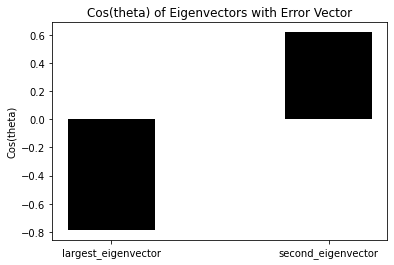

In [36]:
import matplotlib.pyplot as plt

# Values from the outputs related to dot products
eigenvalues = [largest_ev_dot_error_vec, second_ev_dot_error_vec]
eigenvectors = ['largest_eigenvector', 'second_eigenvector']

# Creating the bar plot with thinner bars
plt.bar(eigenvectors, eigenvalues, color=['black', 'black'], width=0.4)  # Adjust the width here
plt.ylabel('Cos(theta)')
plt.title('Cos(theta) of Eigenvectors with Error Vector')
plt.savefig('multicollinearity_barplot.pdf')
plt.show()

Since the error term vector does not align well with the eigenvector of the largest eigenvalue as in the simpson's paradox case, we attribute the error to mechanism 1.

## Verifying the Error Term Expression (June 25th)

In [37]:
# empirical error: beta(w) - beta^{IF}(w) 
beta_w = modified_lr.beta[1]
beta_IF_w = lr.beta[1] + sum(scores[:10])
beta_w - beta_IF_w

-0.0902437127664792

In [38]:
# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs 

array([-78.9808702 ,  83.88445766])

In [39]:
# analytic error: etM2v
M[1:2] @ xstrs

array([-0.09024371])

The error is large when m_err or v_err has a large norm or \angle(m_err, v_err) is large.

In [40]:
np.linalg.norm(M[1:2])

0.001003090945831283

In [41]:
np.linalg.norm(xstrs)

115.21536396617104

In [42]:
norm_m_vec = normalize_vector(M[1:2])[0]
norm_v_vec = normalize_vector(xstrs)

In [43]:
# angle
# normalize_vector(v)
cosine_theta = norm_m_vec @ norm_v_vec
cosine_theta

-0.7808475429712625

# Why does the error vector align with the largest eigenvector of the diff in inverse hessians?

notice that the largest eigenvector aligns well with the vector e1 = (0, 1). this is why the error is large in x, but is it large in the intercept?

In [44]:
# what is the relationship between M and the eigenvectors of M?

# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)

# The operator norm is the largest singular value
normM = np.max(s)
# print(normM) # in the multicollinearity example, we find that the largest eigenvalue is much larger than in the simpson's paradox example.

largest_eigenvector = U[:, 0]
second_eigenvector = U[:, 1]

print(s)
print(U)
print(V)
print(largest_eigenvector) 
# print(second_eigenvector)
# print(V)

[1.00635248e-03 9.92090885e-08]
[[-0.08044497  0.99675905]
 [ 0.99675905  0.08044497]]
[[ 0.08044497 -0.99675905]
 [-0.99675905 -0.08044497]]
[-0.08044497  0.99675905]


In [45]:
print(M)
print(U) # eigenvector 1 , eigenvector 2

[[-6.61107046e-06  8.06856709e-05]
 [ 8.06856709e-05 -9.99840621e-04]]
[[-0.08044497  0.99675905]
 [ 0.99675905  0.08044497]]


In [46]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)
print(f'eigenvalues: {s}')

# The operator norm is the largest singular value
normM = np.max(s)
print(normM)

largest_eigenvector = U[:, 0] # Simpson's Paradox: Largest eigenvalue is 4.00e-03.
second_eigenvector = U[:, 1]

print(largest_eigenvector)

eigenvalues: [1.00635248e-03 9.92090885e-08]
0.0010063524827340436
[-0.08044497  0.99675905]


### Using M1 Rather than the Eigenvector

In [47]:
rs

array([-8.68205568, -8.35462539, -7.40660453, -7.56989077, -7.96482275,
       -8.753709  , -8.06883512, -8.02714742, -7.28850067, -6.86467888])

In [48]:
x1[:, 1] *  rs

array([9.04388716, 8.40163422, 8.9888005 , 6.32822368, 9.3932624 ,
       9.49055015, 7.6630684 , 9.02675852, 8.05958921, 7.48868342])

In [49]:
x1[:, 1] # the x's are on the same magnitude as the r's.

array([-1.04167578, -1.00562668, -1.21361961, -0.83597292, -1.17934356,
       -1.08417474, -0.94971186, -1.12452881, -1.10579522, -1.09090076])

In [50]:
M

array([[-6.61107046e-06,  8.06856709e-05],
       [ 8.06856709e-05, -9.99840621e-04]])

In [51]:
# vector norm of M[:, 1]
np.sqrt(M[0,1]**2 + M[1,1]**2)

0.001003090945831283

In [52]:
M1_norm = normalize_vector(M[:,1])
M1_norm

array([ 0.08043704, -0.99675969])

In [53]:
# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta[1])
rs
xstrs = x1.T @ rs
xstrs

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [54]:
lr.beta[1]

0.7264567487721101

In [55]:
# norm of M
# M[1:2]
print(f'norm of M: {np.linalg.norm(M[1:2])}')
print(f'norm of V: {np.linalg.norm(xstrs)}') 

norm of M: 0.001003090945831283
norm of V: 115.21536396617104


## Verifying Error Term Expression (June 25th)

In [56]:
import math

# empirical error: beta(w) - beta^{IF}(w) 
beta_w = modified_lr.beta[1]
beta_IF_w = lr.beta[1] + sum(scores[:10])
print(beta_IF_w - beta_w)

# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs

# analytic error: etM2v
print(-M[1:2] @ xstrs)

# print norm values
print('norm M:', np.linalg.norm(M[1:2]))
print('norm v:', np.linalg.norm(xstrs))  

# normed vectors
norm_m_vec = normalize_vector(-M[1:2])[0]
norm_v_vec = normalize_vector(xstrs)

# cosine similarity
costheta = norm_m_vec @ norm_v_vec
theta = math.acos(costheta) * (180.0 / math.pi)
print('theta in degrees:', theta)

# new June 25th - should be the same as the old.
print(norm_m_vec)
print(norm_v_vec)

0.0902437127664792
[0.09024371]
norm M: 0.001003090945831283
norm v: 115.21536396617104
theta in degrees: 38.66175873081972
[-0.08043704  0.99675969]
[-0.68550641  0.72806659]


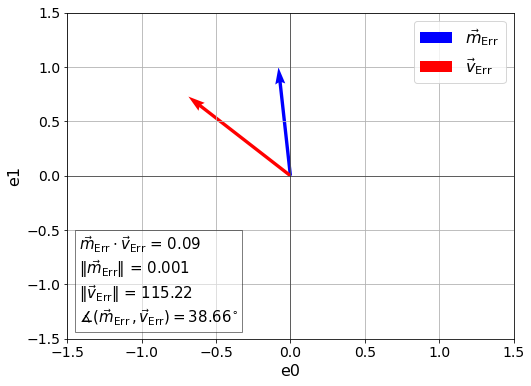

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-1.42243630e-04, -3.99934473e-03]) # M[:, 1]
v1 = norm_m_vec
# v2 = np.array([[-0.03937332, -0.99922457]]) # error vector
v2 = norm_v_vec

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label=r'$\vec{m}_{\mathrm{Err}}$')
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label=r'$\vec{v}_{\mathrm{Err}}$')

textstring = '\n'.join((
    r'$\vec{m}_{\mathrm{Err}} \cdot \vec{v}_{\mathrm{Err}}$ = 0.09',
    r'$\|\vec{m}_{\mathrm{Err}}\|$ = 0.001',
    r'$\|\vec{v}_{\mathrm{Err}}\|$ = 115.22',
    r'$\measuredangle{ (\vec{m}_{\mathrm{Err}}\, , \vec{v}_{\mathrm{Err}}) } = 38.66^{\circ} $'
)) 

# Adding a text box
plt.text(-1.42, -1.36, textstring, fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

# plt.title('Modified Poor Conditioning Example', fontsize=22)
plt.legend(fontsize=16)
plt.savefig('mv.poorconditioning.success.pdf')
plt.show()

### Plotting the eigenvectors

In [38]:
### Multicollinearity Success
largest_eigenvalue = 1.00635248e-03
largest_eigenvector = np.array([-3.95757454e-04, -9.99999922e-01])
norm_error_vector = np.array([0.67911133, -0.73403529])

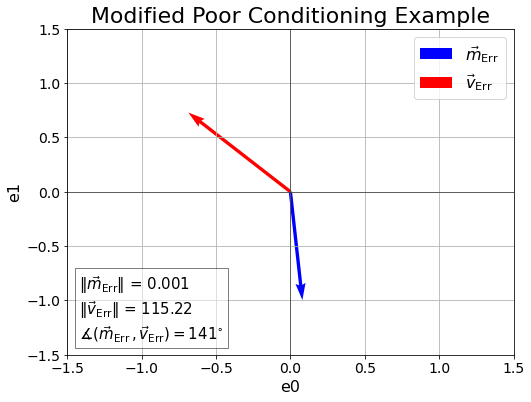

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-1.42243630e-04, -3.99934473e-03]) # M[:, 1]
# v1 = largest_eigenvector
# v2 = np.array([[-0.03937332, -0.99922457]]) # error vector
# v2 = norm_error_vector

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, norm_m_vec[0], norm_m_vec[1], angles='xy', scale_units='xy', scale=1, color="blue", label=r'$\vec{m}_{\mathrm{Err}}$')
plt.quiver(0, 0, norm_v_vec[0], norm_v_vec[1], angles='xy', scale_units='xy', scale=1, color="red", label=r'$\vec{v}_{\mathrm{Err}}$')

textstring = '\n'.join((
    r'$\|\vec{m}_{\mathrm{Err}}\|$ = 0.001',
    r'$\|\vec{v}_{\mathrm{Err}}\|$ = 115.22',
    r'$\measuredangle{ (\vec{m}_{\mathrm{Err}}\, , \vec{v}_{\mathrm{Err}}) } = 141^{\circ} $'
)) 

# Adding a text box
plt.text(-1.42, -1.36, textstring, fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Modified Poor Conditioning Example', fontsize=22)
plt.legend(fontsize=16)
# plt.savefig('modified_poor_conditioning_vectors.pdf')
plt.savefig('modified_poor_conditioning_vectors_june25.pdf')
plt.show()

# Run Code Below to Generate Paper Figures

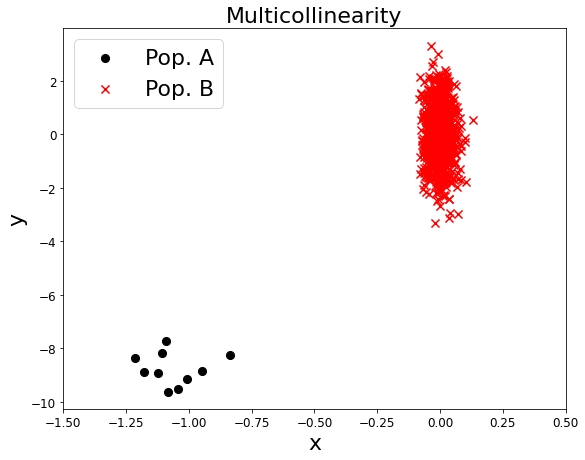

In [26]:
### V. FIGURE FOR PAPER.
plt.figure(figsize=(9, 7))
plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A', s=65) # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B', s=65) # pop B

# Add dropped order positioned by each point
#     for index, row in sorted_if_df.iterrows():
#         if row['sorted_idx'] < 10:
#             plt.text(row['x1']-0.01, row['y'], int(row['sorted_idx']), ha='right', va='bottom', fontsize=20)


plt.xlim(-1.5, 0.5)

plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
plt.ylabel('y', fontsize=22)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=12)  # Larger ticks for x-axis
plt.yticks(fontsize=12)  # Larger ticks for y-axis

plt.title('Multicollinearity', fontsize=22)
plt.legend(fontsize=22)
# plt.savefig('multicollinearity_example_may23.pdf')
plt.show()


In [28]:
norm_error_vec

array([ 0.68139114, -0.73191947])

### Operator Norm of M
Largest eigenvalue is 0.922

### Cos(theta)
the cosine similarity between the largest eigenvector and the error vector is 0.7316; angle = 

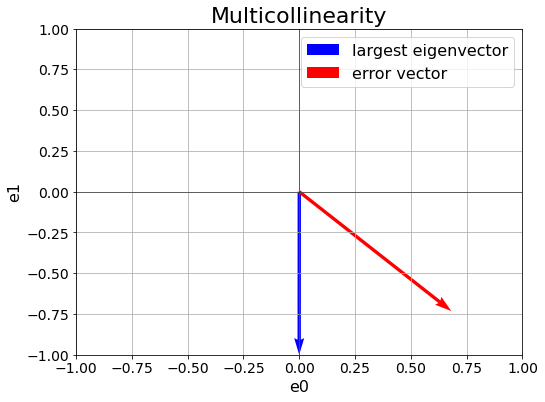

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
v1 = np.array([-3.95757454e-04, -9.99999922e-01])
v2 = np.array([0.68139114, -0.73191947])

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label="largest eigenvector")
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label="error vector")

# Setting the limits and labels
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Multicollinearity', fontsize=22)
plt.legend(fontsize=16)


plt.savefig('multicollinearity_vector_plot.pdf')
plt.show()

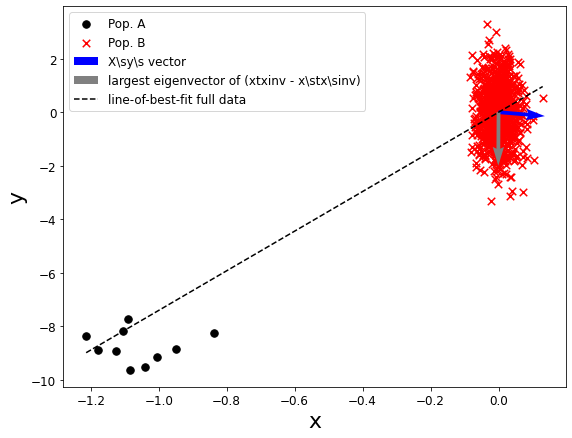

In [27]:
# V. Plot Points Dropped

plt.figure(figsize=(9, 7))

plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A', s=56) # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B', s=56) # pop B

plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
plt.ylabel('y', fontsize=22)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=12)  # Larger ticks for x-axis
plt.yticks(fontsize=12)  # Larger ticks for y-axis

plt.xlabel('x')
plt.ylabel('y')

# Line of best fit
x_values = np.linspace(min(orig_df['x1']), max(orig_df['x1']), 100) # Define range of x values
y_values = lr.beta[1] * x_values + lr.beta[0] # Calculate corresponding y values based on y = 2x

# Define the vector x1y1
vector_x = 0.2*norm_error_vec[0]
vector_y = 0.2*norm_error_vec[1] 

# Plot the vector starting from the origin (0,0)
plt.quiver(0, 0, vector_x, vector_y, angles='xy', scale_units='xy', scale=1, color='blue', label='X\sy\s vector')

# Define the vector largest_eigenvector
eigvec_x = 2*largest_eigenvector[0]
eigvec_y = 2*largest_eigenvector[1]

# Plot the vector starting from the origin (0,0)
plt.quiver(0, 0, eigvec_x, eigvec_y, angles='xy', scale_units='xy', scale=1, color='gray', 
           label='largest eigenvector of (xtxinv - x\stx\sinv)')



plt.plot(x_values, y_values, color='black', linestyle='--', label='line-of-best-fit full data')
plt.legend(fontsize=12)
# plt.savefig('multicollinearity_may17.pdf')
# plt.savefig('multicollinearity_may18.pdf')
plt.show()